## Sentiment Analysis on Movie Reviews using NLP

### Analysis

In [1]:
# Importing required libraries
import string
from time import time
from operator import add
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from keras.preprocessing import text, sequence
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, Flatten, BatchNormalization
from keras.layers.convolutional import Convolution1D, AveragePooling1D
from keras.layers.recurrent import LSTM
from keras.utils import to_categorical

import nltk
from nltk.tokenize import word_tokenize

import wordcloud

%matplotlib inline
seed = 0

Using TensorFlow backend.


In [2]:
# Read the data
train = pd.read_csv("train.tsv", sep='\t')
# A peek of the data
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


We can see that the first 5 phrases are parts of the same sentence, also confirmed by the fact that `SentenceId` is 1 in all cases. Let's recheck by examining another slice of the data.

In [3]:
train.iloc[100:105]

,PhraseId,SentenceId,Phrase,Sentiment
100,101,3,would have a hard time sitting through this one .,1
101,102,3,would have a hard time sitting through this one,0
102,103,3,would,2
103,104,3,have a hard time sitting through this one,0
104,105,3,have,2


Boom! It looks like that multiple reviews are generate by dissecting a single sentence in different ways. And we can see that different parts mean different sentiments. I have added the mapping of `SentimentId` to actual meaning for additional help.
Source = [Kaggle Competition Page](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data)

In [4]:
print("Total types of Sentiments = {}".format(train["Sentiment"].unique()))

Total types of Sentiments = [1 2 3 4 0]


| Sentiment Id |      Sentiment    |
|:------------:|:-----------------:|
|      0       |      Negative     |
|      1       | Somewhat Negative |
|      2       |      Neutral      |
|      3       | Somewhat Positive |
|      4       |      Positive     |

#### Exploratory Analysis

In [5]:
print("Number of reviews = {}".format(train.shape[0]))
print("Number of columns = {}".format(train.shape[1]))
# Count the total number of original sentences
print("Total number of sentences = {}".format(len(train["SentenceId"].unique())))

Number of reviews = 156060
Number of columns = 4
Total number of sentences = 8529


Statistical Analysis of columns won't lead any fruitful results for columns like `PhraseId` and `SentenceId` because their numerical values indicate only the index of a data point. We can instead find number of phrases for each type of Sentiment.

In [6]:
# Get counts of data points for each sentiment
train["Sentiment"].value_counts(sort=False, ascending=True)

0     7072
1    27273
2    79582
3    32927
4     9206
Name: Sentiment, dtype: int64

Observations:-
* The number of reviews which can be classified as strictly positive or negative are less in number.
* A large number of reviews are neutral. I have to take care the classifier doesn't get biased to this.

Now, Let's extract individual words from sentences.

In [7]:
# Tokenize (Separate each word) the phrase
train["Phrase Words"] = train["Phrase"].apply(word_tokenize)
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Phrase Words
0,1,1,A series of escapades demonstrating the adage ...,1,"[A, series, of, escapades, demonstrating, the,..."
1,2,1,A series of escapades demonstrating the adage ...,2,"[A, series, of, escapades, demonstrating, the,..."
2,3,1,A series,2,"[A, series]"
3,4,1,A,2,[A]
4,5,1,series,2,[series]


In [8]:
# Calculate the length of reviews
train["Word Count"] = train["Phrase Words"].apply(len)
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Phrase Words,Word Count
0,1,1,A series of escapades demonstrating the adage ...,1,"[A, series, of, escapades, demonstrating, the,...",37
1,2,1,A series of escapades demonstrating the adage ...,2,"[A, series, of, escapades, demonstrating, the,...",14
2,3,1,A series,2,"[A, series]",2
3,4,1,A,2,[A],1
4,5,1,series,2,[series],1


In [9]:
print("Number of words in shortest review = {}".format(train["Word Count"].min()))
print("Number of words in longest review = {}".format(train["Word Count"].max()))

Number of words in shortest review = 0
Number of words in longest review = 53


Looks like there are some empty reviews with no words.

In [10]:
train[train["Word Count"] == 0]

,PhraseId,SentenceId,Phrase,Sentiment,Phrase Words,Word Count
2005,2006,76,,1,[],0


Phew!! Only 1 empty review! We'll get rid of it during Preprocessing.

#### Visualization

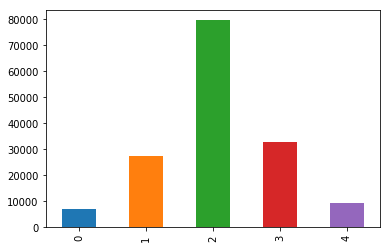

In [11]:
# Distribution of data points among the classes
train["Sentiment"].value_counts(sort=False, ascending=True).plot(kind="bar")

Now, let's have a look at word frequencies.

In [12]:
# Define a function to add empty string to a string
add_empty = partial(add, "")

In [13]:
# Prepare entire text for generating the Word Cloud
all_text = list(map(add_empty, train["Phrase"]))
all_text = " ".join(all_text)

**Imp Note:**: I will be using the wordcloud library for visualizing frequencies of words in the text. It will use it's default *stopwords* automatically, so it's better to supply our set of *stopwords* from `nltk`. <br>

In [14]:
# Generate the Word CLoud
cloud = wordcloud.WordCloud(stopwords=set(nltk.corpus.stopwords.words("english")), random_state=seed)

In [15]:
start = time()
text_cloud = cloud.generate_from_text(all_text)
end = time()
print("Time taken = {:.2f}".format(end - start))

Time taken = 3.25


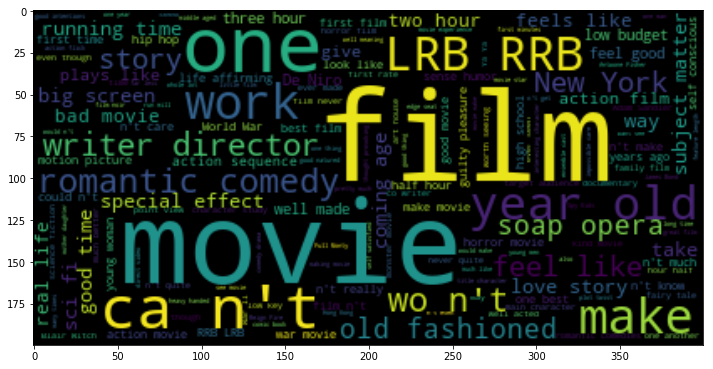

In [16]:
plt.figure(figsize=(12, 8))
plt.imshow(text_cloud, interpolation="bilinear")

* Some of the most common words are `film`, `movie`, `romantic comedy`.
* Words with lesser frequencies are `Every day`, `comic book`, `target audience`.

**Note:**: The max number of words displayed in this wordcloud is decided by `max_words` parameter of the **WordCloud** class. I have kept the default value of 200 for all text to get the big picture. But, when looking at the wordclouds of individual sentiments, I will limit `max_words` to 25 so that differences between top words of all sentiments can be seen clearly.

In [17]:
custom_stopwords = set(nltk.corpus.stopwords.words("english"))
# Updating stopwords with the frequent words from wordcloud which
# seem irrelevant in determining sentiment and punctuation
custom_stopwords.update(["film", "movie", "one", "n't", "like", "LRB", "RRB"])
custom_stopwords.update(list(string.punctuation))

In [18]:
# Create a new Word cloud generator which will consider only the top 100 words
sentiment_cloud = wordcloud.WordCloud(max_words=100, stopwords=custom_stopwords, random_state=seed)

In [19]:
# Extracting slices of dataframe with common sentiment
negative = train[train["Sentiment"] == 0]
somewhat_negative = train[train["Sentiment"] == 1]
neutral = train[train["Sentiment"] == 2]
somewhat_positive = train[train["Sentiment"] == 3]
positive = train[train["Sentiment"] == 4]

#Extracting individual text for all types of sentiments
negative_text = list(map(add_empty, negative["Phrase"]))
negative_text = " ".join(negative_text)

somewhat_negative_text = list(map(add_empty, somewhat_negative["Phrase"]))
somewhat_negative_text = " ".join(somewhat_negative_text)

neutral_text = list(map(add_empty, neutral["Phrase"]))
neutral_text = " ".join(neutral_text)

somewhat_positive_text = list(map(add_empty, somewhat_positive["Phrase"]))
somewhat_positive_text = " ".join(somewhat_positive_text)

positive_text = list(map(add_empty, positive["Phrase"]))
positive_text = " ".join(positive_text)

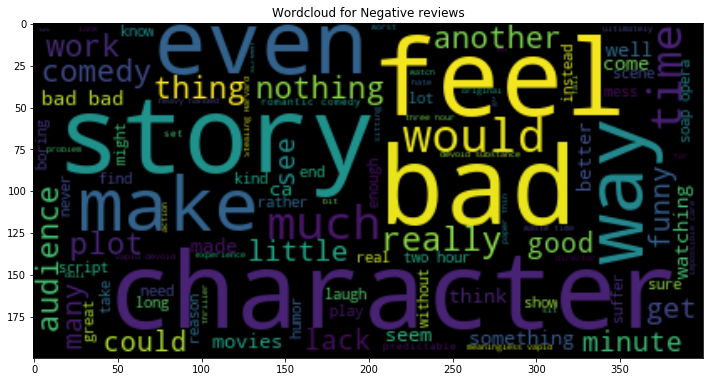

In [20]:
negative_cloud = sentiment_cloud.generate_from_text(negative_text)
plt.figure(figsize=(12, 8))
plt.title("Wordcloud for Negative reviews")
plt.imshow(negative_cloud, interpolation="bilinear")

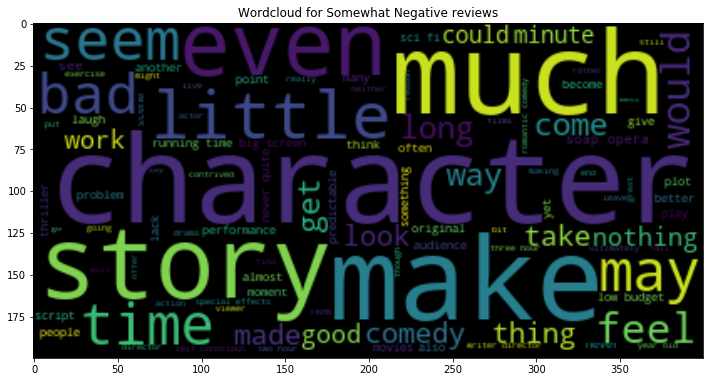

In [21]:
somewhat_negative_cloud = sentiment_cloud.generate_from_text(somewhat_negative_text)
plt.figure(figsize=(12, 8))
plt.title("Wordcloud for Somewhat Negative reviews")
plt.imshow(somewhat_negative_cloud, interpolation="bilinear")

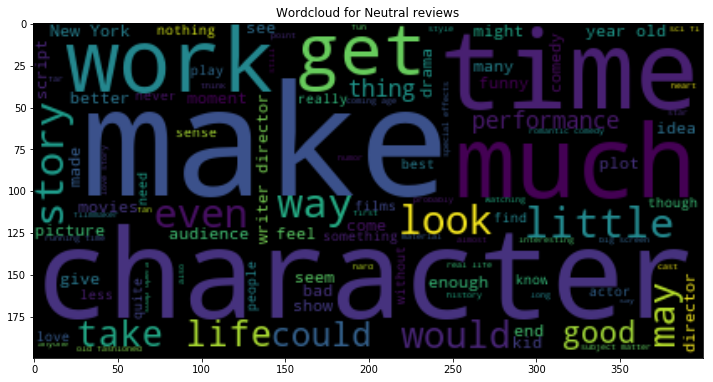

In [22]:
neutral_cloud = sentiment_cloud.generate_from_text(neutral_text)
plt.figure(figsize=(12, 8))
plt.title("Wordcloud for Neutral reviews")
plt.imshow(neutral_cloud, interpolation="bilinear")

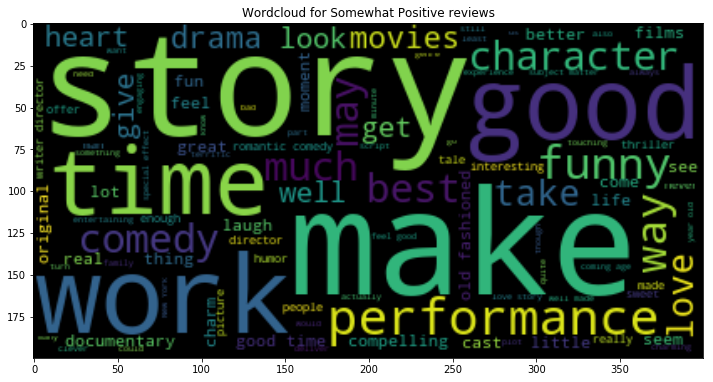

In [23]:
somewhat_positive_cloud = sentiment_cloud.generate_from_text(somewhat_positive_text)
plt.figure(figsize=(12, 8))
plt.title("Wordcloud for Somewhat Positive reviews")
plt.imshow(somewhat_positive_cloud, interpolation="bilinear")

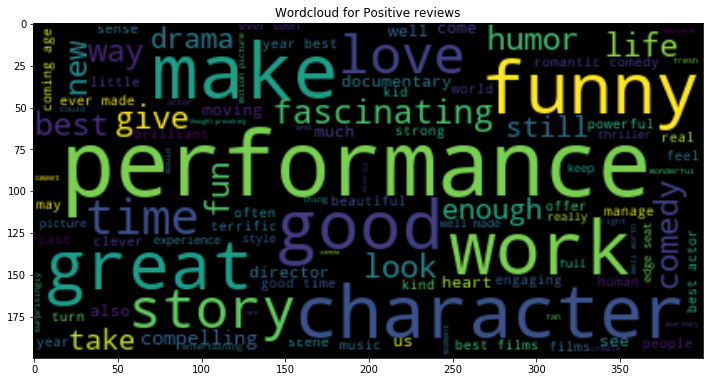

In [24]:
positive_cloud = sentiment_cloud.generate_from_text(positive_text)
plt.figure(figsize=(12, 8))
plt.title("Wordcloud for Positive reviews")
plt.imshow(positive_cloud, interpolation="bilinear")

It can be observed that:-

* Negative reviews include words like bad, nothing, mess.
* Neutral reviews include words character, work, time which don't imply any sentiment.
* Positive reviews include words like good, moving, powerful, best.

#### Benchmark Model

For benchmarking, I am going to use a `NaiveBayes` classifier. This is because probabilistic classifiers are quite popular in text classification and they provide a useful benchmark against more modern methods.

In [25]:
# Divide data in 80/20 ration
X_train, X_test, y_train, y_test = train_test_split(train["Phrase"], train["Sentiment"], test_size=0.2, random_state=seed)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(124848,) (124848,)
(31212,) (31212,)


Class distribution among train and test data

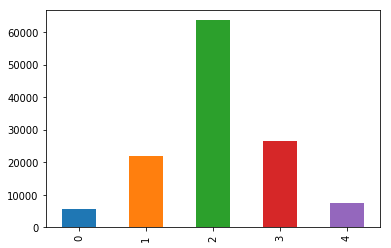

In [26]:
pd.Series(y_train).value_counts(sort=False, ascending=True).plot(kind="bar")

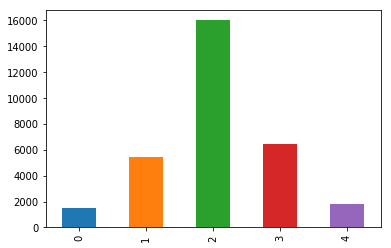

In [27]:
pd.Series(y_test).value_counts(sort=False, ascending=True).plot(kind="bar")

Distribution looks more or less similar between train and test sets.

In [28]:
# Generate count vectors from the data with a maximum of 64 words
vectorizer = CountVectorizer(ngram_range=(1, 5), max_features=64)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.fit_transform(X_test)

In [30]:
# Naive Bayes as a benchmark model
benchmark_model = GaussianNB()

t1 = time()
benchmark_model.fit(X_train.toarray(), y_train)
t2 = time()

print("Model fitted in {:.2f} seconds".format(t2-t1))

# Test accuracy
benchmark_accuracy = accuracy_score(y_test, benchmark_model.predict(X_test.toarray()))
print("Accuracy of benchmark model = {:.2f}%".format(benchmark_accuracy*100))

Model fitted in 0.22 seconds
Accuracy of benchmark model = 44.33%


* Accuracy of a random guess would've been 20%.
* Benchmark model did better than random guessing.
* Still, we can see that there is a lot of room for improvement.

### Data Preprocessing

In [31]:
# Removing stop words
def remove_stopwords(word_list):
    return [word.lower() for word in word_list if word.lower() not in custom_stopwords]

train["Phrase Words Cleaned"] = train["Phrase Words"].apply(lambda x: remove_stopwords(x))
# Recreate text after removing stopwords
train["Phrase Cleaned"] = train["Phrase Words Cleaned"].apply(lambda x: " ".join(x))

# Dropping empty reviews
train["Word Count"] = train["Phrase Words Cleaned"].apply(len)
train = train[train["Word Count"] > 0]

print("Number of records after preprocessing = {}".format(train.shape[0]))

# Split the data in 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(train["Phrase Cleaned"], train["Sentiment"], test_size=0.2, random_state=seed)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Number of records after preprocessing = 154726
(123780,) (123780,)
(30946,) (30946,)


### Preparing Data for the models

In [32]:
# Count vectorizer
vect = CountVectorizer(analyzer="word", max_features=1024)
X_train_count = vect.fit_transform(X_train)
X_test_count = vect.fit_transform(X_test)

In [33]:
# TF-IDF vectorizer
tf_idf = TfidfVectorizer(analyzer="word", max_features=1024)
X_train_tfidf = vect.fit_transform(X_train)
X_test_tfidf = vect.fit_transform(X_test)

In [34]:
# Word2Vec (Word Embeddings)
embeddings = {}
t1 = time()
with open("wiki-news-300d-1M.vec", encoding="utf-8") as vec:
    for i, line in enumerate(vec):
        values = line.split()
        embeddings[values[0]] = np.asarray(values[1:], dtype='float32')
        if (i+1) % 100000 == 0:
            print(i+1)
t2 = time()

print("Time taken load word2vec = {:.2f}".format(t2-t1))

100000
200000
300000
400000
500000
600000
700000
800000
900000
Time taken load word2vec = 79.03


In [35]:
# Create a Tokenizer and build word index of data
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(train["Phrase Cleaned"])
word_index = tokenizer.word_index

# Prepare data for Deep Neural networks
X_train_seq = sequence.pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=32)
X_test_seq = sequence.pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=32)

not_found = 0
# Generate mapping for current words using available word2vec model
mapping = np.zeros((len(word_index)+1, 300))
for word, i in word_index.items():
    embed_vec = embeddings.get(word)
    if embed_vec is not None:
        mapping[i] = embed_vec
    else:
        print("Embedding not found for '{}'".format(word))
        not_found += 1

Embedding not found for 'shindler'
Embedding not found for 'shimizu'
Embedding not found for 'vulakoro'
Embedding not found for 'yosuke'
Embedding not found for 'bogdanich'
Embedding not found for 'deniro'
Embedding not found for 'nakata'
Embedding not found for 'emilie'
Embedding not found for 'tunney'
Embedding not found for 'hirosue'
Embedding not found for 'musker'
Embedding not found for 'marcken'
Embedding not found for 'vittorio'
Embedding not found for 'amini'
Embedding not found for 'powerpuff'
Embedding not found for 'berkley'
Embedding not found for 'shiri'
Embedding not found for 'dudsville'
Embedding not found for 'sugarman'
Embedding not found for 'stoppard'
Embedding not found for 'shatner'
Embedding not found for 'kosashvili'
Embedding not found for 'choquart'
Embedding not found for 'unsalvageability'
Embedding not found for 'nickleby'
Embedding not found for 'truffaut'
Embedding not found for 'gasm'
Embedding not found for 'lilia'
Embedding not found for 'penotti'
Emb

In [36]:
print("Embedding not found for {} words in text".format(not_found))

Embedding not found for 867 words in text


### Implementation

### Algorithms and Techniques

I will be testing the following algorithms on given data (More details in the report):-
1. Gradient Boosting Classifier
2. Multi Layer Perceptron
3. Convolutional Neural Network
4. LSTM Neural Network

**Gradient Boosting Classifier**

In [37]:
# Count vectors
boost_clf = GradientBoostingClassifier(random_state=seed)

t1 = time()
boost_clf.fit(X_train_count, y_train)
t2 = time()
print("Time taken to fit on Count vectors = {}".format(t2-t1))

boost_count_acc = accuracy_score(y_test, boost_clf.predict(X_test_count))
print("Test accuracy using Count Vectors = {}".format(boost_count_acc))

# TF-IDF vectors
boost_clf = GradientBoostingClassifier(random_state=seed)

t1 = time()
boost_clf.fit(X_train_tfidf, y_train)
t2 = time()
print("Time taken to fit on TF-IDF vectors = {}".format(t2-t1))

boost_tfidf_acc = accuracy_score(y_test, boost_clf.predict(X_test_tfidf))
print("Test accuracy using TF-IDF Vectors = {}".format(boost_tfidf_acc))

Time taken to fit on Count vectors = 30.50115942955017
Test accuracy using Count Vectors = 0.5042331803787242
Time taken to fit on TF-IDF vectors = 30.500028133392334
Test accuracy using TF-IDF Vectors = 0.5042331803787242


**Multi Layer Perceptron**

In [38]:
# Count vectors
mlp_clf = MLPClassifier(verbose=True, early_stopping=True, random_state=seed)
t1 = time()
mlp_clf.fit(X_train_count, y_train)
t2 = time()
mlp_count_acc = accuracy_score(y_test, mlp_clf.predict(X_test_count))

# TF-IDF vectors
mlp_clf = MLPClassifier(verbose=True, early_stopping=True, random_state=seed)
t3 = time()
mlp_clf.fit(X_train_tfidf, y_train)
t4 = time()
mlp_tfidf_acc = accuracy_score(y_test, mlp_clf.predict(X_test_tfidf))

print("\nTime taken to fit on Count vectors = {}".format(t2-t1))
print("Test accuracy using Count Vectors = {}".format(mlp_count_acc))
print("Time taken to fit on TF-IDF vectors = {}".format(t4-t3))
print("Test accuracy using TF-IDF Vectors = {}".format(mlp_tfidf_acc))

Iteration 1, loss = 1.20214948
Validation score: 0.584101
Iteration 2, loss = 1.06000095
Validation score: 0.590645
Iteration 3, loss = 1.03630167
Validation score: 0.593392
Iteration 4, loss = 1.01593727
Validation score: 0.598724
Iteration 5, loss = 0.99638423
Validation score: 0.598158
Iteration 6, loss = 0.97762022
Validation score: 0.603409
Iteration 7, loss = 0.96019596
Validation score: 0.604783
Iteration 8, loss = 0.94388097
Validation score: 0.606398
Iteration 9, loss = 0.92855682
Validation score: 0.608741
Iteration 10, loss = 0.91541982
Validation score: 0.609872
Iteration 11, loss = 0.90332883
Validation score: 0.608984
Iteration 12, loss = 0.89207142
Validation score: 0.608822
Iteration 13, loss = 0.88150220
Validation score: 0.608095
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.20214948
Validation score: 0.584101
Iteration 2, loss = 1.06000095
Validation score: 0.590645
Iteration 3, loss = 1.03630167
V

**Convolutional Neural Network**

In [40]:
# Converting labels to one hot encoded format for Deep neural networks

y_train_dnn = to_categorical(y_train)
y_test_dnn = to_categorical(y_test)

print(y_train_dnn.shape, y_test_dnn.shape)

(123780, 5) (30946, 5)


In [41]:
# Convolutional Neural Network Architecture

# Input layer
input_layer = Input((32,))
# Embedding layer
embedding_layer = Embedding(len(word_index) + 1, 300, weights=[mapping], trainable=False)(input_layer)
# Convolution + Pooling
conv1 = Convolution1D(32, 3, activation="relu")(embedding_layer)
pool1 = AveragePooling1D()(conv1)
conv2 = Convolution1D(64, 3, activation="relu")(pool1)
pool2 = AveragePooling1D()(conv2)
# Flatten layer for before Dense
flatten = Flatten()(pool2)
# Output layer
fc = Dense(128, activation="relu")(flatten)
output_layer = Dense(5, activation="softmax")(fc)

# Compiling the model - deciding loss function and optimizer
cnn = Model(inputs=input_layer, outputs=output_layer)
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 32, 300)           4566600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 32)            28832     
_________________________________________________________________
average_pooling1d_1 (Average (None, 15, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 64)            6208      
_________________________________________________________________
average_pooling1d_2 (Average (None, 6, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
__________

In [42]:
# Train the CNN
cnn.fit(X_train_seq, y_train_dnn, batch_size=64, epochs=5)

Epoch 1/5
123780/123780 [==============================] - 18s 149us/step - loss: 1.1402 - acc: 0.5597
Epoch 2/5
123780/123780 [==============================] - 19s 151us/step - loss: 1.0812 - acc: 0.5835
Epoch 3/5
123780/123780 [==============================] - 19s 152us/step - loss: 1.0471 - acc: 0.5976
Epoch 4/5
123780/123780 [==============================] - 19s 151us/step - loss: 1.0230 - acc: 0.6078
Epoch 5/5
123780/123780 [==============================] - 19s 151us/step - loss: 1.0046 - acc: 0.6157


In [43]:
# Test accuracy of CNN
cnn.evaluate(X_test_seq, y_test_dnn)

30946/30946 [==============================] - 2s 81us/step


[1.0664935122939678, 0.589510760679894]

**LSTM Neural Network**

In [44]:
# LSTM Neural Network Architecture

# Input Layer
input_layer = Input((32,))

# Embedding Layer
embedding_layer = Embedding(len(word_index) + 1, 300, weights=[mapping], trainable=False)(input_layer)

# ALSTM Layer
lstm1 = LSTM(128)(embedding_layer)

# Output Layers
fc = Dense(64, activation="relu")(lstm1)
output_layer = Dense(5, activation="softmax")(fc)

# Compiling the model - deciding loss function and optimizer
lstm = Model(inputs=input_layer, outputs=output_layer)
lstm.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 32, 300)           4566600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 4,794,829
Trainable params: 228,229
Non-trainable params: 4,566,600
_________________________________________________________________


In [45]:
# Train the LSTM
lstm.fit(X_train_seq, y_train_dnn, batch_size=64, epochs=5)

Epoch 1/5
123780/123780 [==============================] - 94s 763us/step - loss: 0.9491 - acc: 0.6088
Epoch 2/5
123780/123780 [==============================] - 95s 766us/step - loss: 0.8846 - acc: 0.6327
Epoch 3/5
123780/123780 [==============================] - 95s 766us/step - loss: 0.8507 - acc: 0.6481
Epoch 4/5
123780/123780 [==============================] - 94s 760us/step - loss: 0.8146 - acc: 0.6633
Epoch 5/5
123780/123780 [==============================] - 94s 761us/step - loss: 0.7787 - acc: 0.6781


In [46]:
# Test accuracy of LSTM
lstm.evaluate(X_test_seq, y_test_dnn)

30946/30946 [==============================] - 10s 336us/step


[0.8260822131298543, 0.6613455697020617]

* It can be observed that LSTM outperforms all other networks.
* Also, it has been established in the field of Deep learning that LSTM works really great on text data.
* Hence, I will pick LSTM as my model to be refined further.

### Model Refinement

In [69]:
# Refined LSTM Architecture

# Input Layer
input_layer = Input((32,))

# Embedding Layer
embedding_layer = Embedding(len(word_index) + 1, 300, weights=[mapping], trainable=False)(input_layer)
embedding_layer = SpatialDropout1D(0.25)(embedding_layer)

# Add Dropout to LSTM Layer
lstm1 = LSTM(256, dropout=0.25)(embedding_layer)

# Add Batch Normalization
batch_norm = BatchNormalization()(lstm1)

# Add 1 more Dense layer and apply Dropout to both the Dense layers
fc1 = Dense(128, activation="relu")(batch_norm)
dropout1 = Dropout(0.5)(fc1)
fc2 = Dense(64, activation="relu")(dropout1)
dropout2 = Dropout(0.25)(fc2)
output_layer = Dense(5, activation="softmax")(dropout2)

# Compile the model - Deciding optimizer and loss function
lstm = Model(inputs=input_layer, outputs=output_layer)
lstm.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 32)                0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 32, 300)           4566600   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 32, 300)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               570368    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_22 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
__________

In [70]:
# Fit the Tuned LSTM
lstm.fit(X_train_seq, y_train_dnn, batch_size=512, epochs=50)

Epoch 1/50
123780/123780 [==============================] - 132s 1ms/step - loss: 1.1048 - acc: 0.5500
Epoch 2/50
123780/123780 [==============================] - 130s 1ms/step - loss: 1.0097 - acc: 0.5865
Epoch 3/50
123780/123780 [==============================] - 131s 1ms/step - loss: 0.9867 - acc: 0.5938
Epoch 4/50
123780/123780 [==============================] - 130s 1ms/step - loss: 0.9696 - acc: 0.6005
Epoch 5/50
123780/123780 [==============================] - 130s 1ms/step - loss: 0.9581 - acc: 0.6050
Epoch 6/50
123780/123780 [==============================] - 131s 1ms/step - loss: 0.9495 - acc: 0.6102
Epoch 7/50
123780/123780 [==============================] - 130s 1ms/step - loss: 0.9421 - acc: 0.6124
Epoch 8/50
123780/123780 [==============================] - 130s 1ms/step - loss: 0.9332 - acc: 0.6160
Epoch 9/50
123780/123780 [==============================] - 130s 1ms/step - loss: 0.9253 - acc: 0.6180
Epoch 10/50
123780/123780 [==============================] - 131s 1ms/ste

### Model Evaluation and Validation

In [71]:
# Test accuracy of tuned LSTM
lstm.evaluate(X_test_seq, y_test_dnn)

30946/30946 [==============================] - 23s 728us/step


[0.7939409885900034, 0.6739481677761262]

### Justification

| Model | Test Accuracy |
|:-----:|:-------------:|
| Naive Bayes (Benchmark) | 44.33% |
| Tuned LSTM (Final Model) | 67.39% |

* An accuracy increase of 23.06% is observed from the benchmark model.
* A key advantage of LSTM over Naive Bayes is that while Naive Bayes treats each word differently, LSTM uses memory to process sequences, which makes it a better choice for sequential data.
* Hence, it can concluded that the choice LSTM for given problem and data is justified.

### Free form visualization

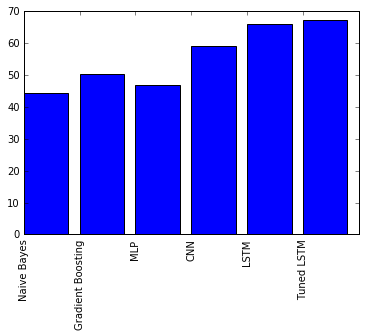

In [24]:
models = ["Naive Bayes", "Gradient Boosting", "MLP", "CNN", "LSTM", "Tuned LSTM"]
test_accuracies = [44.33, 50.42, 46.89, 58.95, 66.13, 67.39]

plt.bar(np.arange(len(test_accuracies)), test_accuracies)
_ = plt.xticks(np.arange(len(models)), models, rotation=90)

Observations from Free form visualization:-
1. The choice of benchmark model is correct as it is both simple and has a low accuracy.
2. Neural networks don't always perform the best. (Gradient Boosting > MLP)
3. Although, CNNs are more used for Image data, they show considerably good performance on Text data as well.
4. In absence of proper hyperparameter tuning, accuracy gains on Deep networks can be quite low (LSTM ~ Tuned LSTM).